In [1]:
# import everything needed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# modeling libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, LabelEncoder

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import plot_tree
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from pandas.plotting import parallel_coordinates

import warnings
warnings.filterwarnings('ignore')

In [2]:
def prepare_data(df):
    """
    Prepare the data for modeling with proper handling of mixed data types.
    """
    df = df.copy()
    
    # Define feature sets
    predictor_features = [
        'average_weather_before',
        'most_common_surface', 'most_common_roof', 'average_snaps_before',
        'sum_travel_magnitude', 'sum_tz_diff_magnitude', 'sum_elevation_difference',
        'prev_weather', 'prev_wind', 'prev_surface', 'prev_roof',
        'prev_snaps', 'prev_travel_magnitude', 'prev_is_international',
        'prev_elevation_difference', 'prev_travel_direction', 'prev_elevation_difference_abs_m'
    ]
    
    performance_features = [
        'pass_cmp_x', 'pass_att', 'pass_yds', 'pass_td', 'pass_int', 'pass_sacked_x',
        'pass_sacked_yds', 'pass_long', 'pass_rating', 'rush_att_x', 'rush_yds_x',
        'rush_td_x', 'rush_long', 'targets_x', 'rec_x', 'rec_yds_x', 'rec_td_x',
        'rec_long', 'fumbles', 'fumbles_lost', 'def_int_x', 'def_int_yds',
        'def_int_td', 'def_int_long', 'pass_defended', 'sacks_x', 'tackles_combined_x',
        'tackles_solo', 'tackles_assists', 'tackles_loss', 'qb_hits', 'fumbles_rec',
        'fumbles_rec_yds', 'fumbles_rec_td', 'fumbles_forced', 'xpm', 'xpa', 'fgm',
        'fga', 'punt', 'punt_yds', 'punt_yds_per_punt', 'punt_long', 'kick_ret',
        'kick_ret_yds', 'kick_ret_yds_per_ret', 'kick_ret_td', 'kick_ret_long',
        'punt_ret', 'punt_ret_yds', 'punt_ret_yds_per_ret', 'punt_ret_td',
        'punt_ret_long', 'pass_first_down', 'pass_first_down_pct', 'pass_target_yds',
        'pass_tgt_yds_per_att', 'pass_air_yds', 'pass_air_yds_per_cmp',
        'pass_air_yds_per_att', 'pass_yac', 'pass_yac_per_cmp', 'pass_drops',
        'pass_drop_pct', 'pass_poor_throws', 'pass_poor_throw_pct', 'pass_sacked_y',
        'pass_blitzed', 'pass_hurried', 'pass_hits', 'pass_pressured',
        'pass_pressured_pct', 'rush_scrambles', 'rush_scrambles_yds_per_att',
        'rush_first_down', 'rush_yds_before_contact', 'rush_yds_bc_per_rush',
        'rush_yac', 'rush_yac_per_rush', 'rush_broken_tackles',
        'rush_broken_tackles_per_rush', 'rec_first_down', 'rec_air_yds',
        'rec_air_yds_per_rec', 'rec_yac', 'rec_yac_per_rec', 'rec_adot',
        'rec_broken_tackles', 'rec_broken_tackles_per_rec', 'rec_drops',
        'rec_drop_pct', 'rec_target_int', 'rec_pass_rating', 'def_targets',
        'def_cmp', 'def_cmp_perc', 'def_cmp_yds', 'def_yds_per_cmp',
        'def_yds_per_target', 'def_cmp_td', 'def_pass_rating', 'def_tgt_yds_per_att',
        'def_air_yds', 'def_yac', 'blitzes', 'qb_hurry', 'qb_knockdown', 'pressures',
        'tackles_missed', 'tackles_missed_pct', 'avg_snap_count_after'
    ]
    
    # Filter to only existing columns
    predictor_features = [col for col in predictor_features if col in df.columns]
    performance_features = [col for col in performance_features if col in df.columns]
    
    print(f"Found {len(predictor_features)} predictor features")
    print(f"Found {len(performance_features)} performance features")
    
    # Create binary target for injury prediction
    print("\nCreating injury severity target...")
    if 'game_status' in df.columns:
        # Clean game_status column
        df['game_status'] = df['game_status'].astype(str).str.strip().str.lower()
        
        # Map to severity
        severity_map = {
            'out': 2,
            'doubtful': 1,
            'questionable': 1,
            'probable': 0,
            'nan': np.nan,
            'none': np.nan
        }
        
        df['injury_severity'] = df['game_status'].map(severity_map)

        print(f"Injury severity distribution:")
        print(df['injury_severity'].value_counts(dropna=False))
    else:
        print("Warning: 'game_status' column not found, cannot create injury severity")
        df['injury_severity'] = np.nan
    
    # Handle missing values separately for numeric and categorical columns
    print("\nHandling missing values...")
    
    # Identify numeric vs categorical columns
    numeric_predictors = []
    categorical_predictors = []
    
    # loop through the predictor variables in df columns
    for col in predictor_features:
        if col in df.columns:
            # Try to convert to numeric to check
            numeric_test = pd.to_numeric(df[col], errors='coerce')
            numeric_count = numeric_test.notna().sum()
            total_count = df[col].notna().sum()
            
            if numeric_count > 0 and (numeric_count / total_count > 0.5 if total_count > 0 else False):
                numeric_predictors.append(col)
            else:
                categorical_predictors.append(col)
    
    print(f"Numeric predictors: {len(numeric_predictors)}")
    print(f"Categorical predictors: {len(categorical_predictors)}")
    
    # Fill missing values for numeric columns
    if numeric_predictors:
        for col in numeric_predictors:
            # Extract numbers from strings like ("56%")
            if df[col].dtype == object:
                # Clean the column first
                df[col] = df[col].astype(str).str.extract(r'([-+]?\d*\.?\d+)')[0]
            
            # Convert to numeric
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
            # Fill missing with median
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
    
    # Fill missing values for categorical columns
    if categorical_predictors:
        for col in categorical_predictors:
            # Fill with mode (most common value)
            if df[col].notna().sum() > 0:
                mode_val = df[col].mode().iloc[0] if len(df[col].mode()) > 0 else 'Unknown'
            else:
                mode_val = 'Unknown'
            
            df[col] = df[col].fillna(mode_val)
    
    # Fill missing values for performance features
    for col in performance_features:
        if col in df.columns:
            # Clean if string
            if df[col].dtype == object:
                df[col] = df[col].astype(str).str.extract(r'([-+]?\d*\.?\d+)')[0]
            
            # Convert to numeric
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
            # Fill missing with median
            if df[col].notna().sum() > 0:
                median_val = df[col].median()
                df[col] = df[col].fillna(median_val)
    
    # Encode categorical features
    print("\nEncoding categorical features...")
    
    # Identify which categorical columns to encode
    categorical_cols = ['most_common_surface', 'most_common_roof', 
                       'prev_surface', 'prev_roof', 'prev_travel_direction']
    
    # Filter to only columns that exist and are categorical
    categorical_cols = [col for col in categorical_cols if col in df.columns and col in categorical_predictors]
    
    label_encoders = {}
    for col in categorical_cols:
        try:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le
            print(f"  Encoded {col}: {len(le.classes_)} categories")
        except Exception as e:
            print(f"  Warning: Could not encode {col}: {e}")
            # Keep as is or create dummy variables
    
    print(f"\nFinal prepared data shape: {df.shape}")
    
    return df, predictor_features, performance_features

In [3]:
def debug_data_pipeline(df, features, stage_name=""):
    """Debug function to check data at different pipeline stages."""
    
    print(f"\n{'='*60}")
    print(f"DEBUG: {stage_name}")
    print(f"{'='*60}")
    
    print(f"Data shape: {df.shape}")
    print(f"Number of features: {len(features)}")
    
    # Check selected features
    if features:
        X = df[features]
        print(f"Selected features shape: {X.shape}")
        
        # Check for NaN values
        nan_counts = X.isna().sum()
        total_nans = nan_counts.sum()
        # print(f"Total NaN values: {total_nans}")
        
        if total_nans > 0:
            # print("\nFeatures with NaN values:")
            for feature, count in nan_counts[nan_counts > 0].items():
                percentage = (count / len(X)) * 100
                # print(f"  {feature}: {count} NaNs ({percentage:.1f}%)")
                
            # Show sample of rows with NaN
            nan_rows = X.isna().any(axis=1)
            # print(f"\nRows with NaN: {nan_rows.sum()}")
            if nan_rows.sum() > 0:
                # print("\nSample of rows with NaN:")
                sample = X[nan_rows].head(3)
                for idx, row in sample.iterrows():
                    nan_cols = row[row.isna()].index.tolist()
                    # print(f"  Row {idx}: NaN in {nan_cols}")
    
    # Check data types
    # print(f"\nData types in selected features:")
    if features:
        print(df[features].dtypes.value_counts())
    
    return total_nans if features else 0

In [4]:
def model_injury_risk(df, predictor_features):
    """
    Model Type 1: Predict injury risk based on pre-injury features.
    - Will use a Random Forest and XGB Models
    """
    print("=" * 60)
    print("MODEL 1: INJURY RISK PREDICTION")
    print("=" * 60)
    
    # Check if we have the target column
    if 'injury_severity' not in df.columns:
        print("Warning: 'injury_severity' column not found")
        return {}
    
    # Check for NaN in target
    nan_count = df['injury_severity'].isna().sum()
    print(f"Target column 'injury_severity' has {nan_count} NaN values")
    
    # Remove rows with NaN in target
    df_clean = df.dropna(subset=['injury_severity']).copy()
    
    if len(df_clean) == 0:
        print("Error: No valid injury severity data after removing NaN")
        return {}
    
    print(f"Using {len(df_clean)} samples after removing NaN from target")
    
    # Prepare data
    X = df_clean[predictor_features]
    y = df_clean['injury_severity']  # Multi-class: 0=minor, 1=moderate, 2=severe
    
    # Convert y to integer if it's float
    if y.dtype == float:
        y = y.astype(int)
    
    print(f"Target distribution:")
    print(y.value_counts().sort_index())
    
    # Check if we have enough samples for each class
    class_counts = y.value_counts()
    min_samples = class_counts.min()
    print(f"Minimum class samples: {min_samples}")
    
    # Split data
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
    except ValueError as e:
        print(f"Stratified split failed: {e}")
        print("Using regular split instead...")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
    
    print(f"\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}")

    non_numeric = X_train.select_dtypes(include=["object"])
    print(non_numeric.columns)
    print(non_numeric.head())
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # store original features
    y_train_original = y_train.copy()
    y_test_original = y_test.copy()

    print(f"Original label distribution in training set: {np.unique(y_train_original, return_counts=True)}")
    print(f"Original label distribution in test set: {np.unique(y_test_original, return_counts=True)}")

    # Train models
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric="logloss")
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # need to change the labels for XGB (from [1, 2] to [0, 1])
        try:
            if name == "Random Forest":
                print("Not changing labels")
            if name == "XGBoost":
                print("Converting labels from [1, 2] to [0, 1]...") 
                y_train = np.where(y_train == 1, 0, 1)
                y_test = np.where(y_test == 1, 0, 1)
            
            # Train
            model.fit(X_train_scaled, y_train)
            
            # Predict
            y_pred = model.predict(X_test_scaled)
            
            # Evaluate
            print(f"Accuracy: {model.score(X_test_scaled, y_test):.3f}")
            print("Classification Report:")
            print(classification_report(y_test, y_pred, 
                  target_names=['Minor', 'Moderate']))
            
            # Feature importance
            if hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_
                feature_importance = pd.DataFrame({
                    'feature': predictor_features,
                    'importance': importances
                }).sort_values('importance', ascending=False)
                
                print("\nTop 10 Most Important Features for Injury Prediction:")
                print(feature_importance.head(10).to_string(index=False))
                
                # Plot feature importance to chart which features are most significant in the model
                plt.figure(figsize=(10, 6))
                plt.barh(feature_importance.head(10)['feature'], 
                        feature_importance.head(10)['importance'])
                plt.xlabel('Importance')
                plt.title(f'{name} - Top 10 Injury Risk Features')
                plt.gca().invert_yaxis()
                plt.tight_layout()
                plt.show()

                plt.figure(figsize=(20,10))
                plot_tree(model.estimators_[0], # will fail for XGBoost
                        feature_names=X.columns,
                        class_names=model.classes_.astype(str),
                        filled=True,
                        rounded=True,
                        max_depth=3) 
                plt.title(f"Decision Tree #{0}")
                plt.show()
                
                results[name] = {
                    'model': model,
                    'feature_importance': feature_importance,
                    'scaler': scaler
                }
                
        except Exception as e:
            print(f"Error training {name}: {e}")
            continue
    
    return results

In [5]:
def model_post_injury_performance(df, predictor_features, performance_features):
    """
    Model Type 2: Predict post-injury performance based on injury characteristics.
    """
    print("\n" + "=" * 60)
    print("MODEL 2: POST-INJURY PERFORMANCE PREDICTION")
    print("=" * 60)
        
    # Prepare data
    df_model = df.copy()
    
    # Encode injury features
    le_injury = LabelEncoder()
    df_model['injury_lcoation_encoded'] = le_injury.fit_transform(
        df_model['injury_lcoation'].fillna('Unknown').astype(str)
    )
    
    le_practice = LabelEncoder()
    df_model['practice_status_encoded'] = le_practice.fit_transform(
        df_model['practice_status'].fillna('Unknown').astype(str)
    )
    
    le_position = LabelEncoder()
    df_model['position_encoded'] = le_position.fit_transform(
        df_model['position'].fillna('Unknown').astype(str)
    )
    
    # Combine features
    X_features = ['injury_lcoation_encoded', 'practice_status_encoded', 'position_encoded']
    original_feature_names = ['injury_location', 'practice_status', 'position']  # for importances
    X = df_model[X_features]
    
    performance_results = {}
    
    # Predict each performance metric
    print(f"\nPredicting {len(performance_features)} performance metrics...")
    
    for i, target_col in enumerate(performance_features[:10]):  # Limit to first 10 for demo
    # for i, target_col in enumerate(performance_features):
        if target_col not in df_model.columns:
            continue
            
        print(f"\n{target_col}...")
        
        y = df_model[target_col]
        
        # Remove rows where target is NaN
        valid_idx = y.notna()
        X_clean = X[valid_idx]
        y_clean = y[valid_idx]
        
        if len(y_clean) < 20:  # Need enough data
            continue
        
        # Impute
        imputer = SimpleImputer(strategy='mean')
        X_imputed = imputer.fit_transform(X_clean)
        
        # Split
        X_train, X_test, y_train, y_test = train_test_split(
            X_imputed, y_clean, test_size=0.2, random_state=42
        )

        # Scale
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train model
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train_scaled, y_train)
        
        # Predict
        y_pred = model.predict(X_test_scaled)

        # evaluate model
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)

        # visualize results
        importances = model.feature_importances_
        feature_importance = pd.DataFrame({
            'feature': original_feature_names,  # Use original names for readability
            'encoded_feature': X_features,  # The actual feature names
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print(f"\n  Feature Importance for Predicting {target_col}:")
        print(feature_importance.to_string(index=False))
        
        # Visualize feature importance
        plt.figure(figsize=(10, 6))
        
        # Create horizontal bar chart
        bars = plt.barh(range(len(feature_importance)), feature_importance['importance'])
        plt.yticks(range(len(feature_importance)), feature_importance['feature'])
        plt.xlabel('Importance Score', fontsize=12)
        plt.title(f'Feature Importance for Predicting {target_col}\n(R² = {r2:.3f})', 
                  fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()  # Highest importance on top
        
        # Add importance values on bars
        for i, (bar, importance) in enumerate(zip(bars, feature_importance['importance'])):
            width = bar.get_width()
            plt.text(width + max(feature_importance['importance']) * 0.01, i, 
                    f'{importance:.4f}', va='center', fontsize=10)
        
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Additional: Actual vs Predicted scatter plot
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, alpha=0.6, edgecolor='k', linewidth=0.5)
        
        # Add perfect prediction line
        min_val = min(y_test.min(), y_pred.min())
        max_val = max(y_test.max(), y_pred.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, label='Perfect Prediction')
        
        plt.xlabel('Actual Values', fontsize=12)
        plt.ylabel('Predicted Values', fontsize=12)
        plt.title(f'Actual vs Predicted: {target_col}\nR² = {r2:.3f}', fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Store results
        performance_results[target_col] = {
            'model': model,
            'scaler': scaler,
            'imputer': imputer,
            'r2': r2,
            'mse': mse,
            'mae': mae,
            'feature_importance': feature_importance,
            'y_test': y_test,
            'y_pred': y_pred,
            'label_encoders': {
                'injury_location': le_injury,
                'practice_status': le_practice,
                'position': le_position
            }
        }
    
    print(f"\n{'='*50}")
    print(f"Completed {len(performance_results)} performance models")
    print(f"{'='*50}")
    
    return performance_results


In [ ]:

# ============================================================================
# MODEL 3: Integrated Analysis - Connecting Injury Risk to Performance
# ============================================================================

def integrated_analysis(df, predictor_features, performance_features):
    """
    Integrated analysis combining performance metrics with injury predictions.
    """

    print("=" * 60)
    print("Starting Integrated Analysis")
    print("=" * 60)
    
    # Create combined feature set
    analysis_features = predictor_features + performance_features
    
    # Debug: Check initial data
    debug_data_pipeline(df, analysis_features, "Initial Data")
    
    # Create a robust preprocessing pipeline
    preprocessing_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean', add_indicator=False)),
        ('scaler', StandardScaler())
    ])
    
    try:
        # Extract data
        X = df[analysis_features].values
        
        # Debug: Check raw numpy array
        print(f"\nRaw numpy array shape: {X.shape}")
        print(f"NaN count in raw array: {np.isnan(X).sum()}")
        
        # Apply preprocessing
        X_scaled = preprocessing_pipeline.fit_transform(X)
        
        # Debug: Check after preprocessing
        print(f"\nAfter preprocessing shape: {X_scaled.shape}")
        nan_count = np.isnan(X_scaled).sum()
        print(f"NaN count after preprocessing: {nan_count}")
        
        # Force any remaining NaN to be handled
        if nan_count > 0:
            print(f"\nWARNING: {nan_count} NaN values still exist!")
            print("Replacing NaN with column means...")
            
            # Calculate column means ignoring NaN
            col_means = np.nanmean(X_scaled, axis=0)
            
            # Replace NaN with column means
            nan_mask = np.isnan(X_scaled)
            for col_idx in range(X_scaled.shape[1]):
                col_nan_mask = nan_mask[:, col_idx]
                if col_nan_mask.any():
                    X_scaled[col_nan_mask, col_idx] = col_means[col_idx]
            
            print(f"NaN count after force-clean: {np.isnan(X_scaled).sum()}")
        
        # Final verification
        if np.isnan(X_scaled).any():
            print("\nERROR: NaN values still exist after all cleaning!")
            print("Using np.nan_to_num as last resort...")
            X_scaled = np.nan_to_num(X_scaled)
        
        # Verify no NaN remain
        final_nan_count = np.isnan(X_scaled).sum()
        if final_nan_count > 0:
            raise ValueError(f"Failed to remove all NaN values. Remaining: {final_nan_count}")
        
        print(f"\nData preparation successful")
        print(f"Final data shape: {X_scaled.shape}")
        print(f"No NaN values remaining")
        
        # Clustering analysis - Elbow Method
        print("\nPerforming clustering analysis...")
        k_range = range(2, 11)

        inertias = []
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(X_scaled)
            inertias.append(kmeans.inertia_)
            print(f"  K={k}, Inertia={kmeans.inertia_:.2f}")
        
        # Create elbow plot
        plt.figure(figsize=(10, 6))
        plt.plot(k_range, inertias, marker='o', linewidth=2, markersize=8)
        plt.xlabel('Number of Clusters (k)', fontsize=12)
        plt.ylabel('Inertia (Within-cluster Sum of Squares)', fontsize=12)
        plt.title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        
        # Find elbow point (simple method - point of maximum curvature)
        if len(inertias) >= 3:
            # Calculate second derivatives
            second_derivatives = []
            for i in range(1, len(inertias)-1):
                # Central difference approximation of second derivative
                second_deriv = inertias[i-1] - 2*inertias[i] + inertias[i+1]
                second_derivatives.append(second_deriv)
            
            if second_derivatives:
                # Find index of maximum second derivative (point of maximum curvature)
                max_second_deriv_idx = second_derivatives.index(max(second_derivatives))
                optimal_k = max_second_deriv_idx + 2  # +2 because k starts at 2
                
                # Ensure optimal_k is within reasonable bounds
                optimal_k = max(2, min(optimal_k, len(k_range)))
                
                plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7, 
                           label=f'Optimal K={optimal_k}')
                plt.legend()
        else:
            optimal_k = 4  # Default if we can't calculate
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nSelected Optimal K = {optimal_k} based on elbow method")
        
        # Final clustering
        kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        df['Cluster'] = kmeans_final.fit_predict(X_scaled)
        
        # Analyze clusters
        cluster_summary = df.groupby('Cluster')[analysis_features].mean()

        print("\n" + "="*60)
        print("Cluster Distribution")
        print("="*60)
        
        plt.figure(figsize=(10, 6))
        cluster_counts = df['Cluster'].value_counts().sort_index()
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'][:optimal_k]
        bars = plt.bar(cluster_counts.index, cluster_counts.values, color=colors)
        
        plt.xlabel('Cluster', fontsize=12)
        plt.ylabel('Number of Samples', fontsize=12)
        plt.title(f'Cluster Distribution (Total: {len(df):,} samples)', fontsize=14, fontweight='bold')
        plt.xticks(cluster_counts.index)
        
        # Add count labels on bars
        for bar, count in zip(bars, cluster_counts.values):
            height = bar.get_height()
            percentage = (count / len(df)) * 100
            plt.text(bar.get_x() + bar.get_width()/2., height + max(cluster_counts.values)*0.01,
                    f'{count:,}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=10)
        
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print("\nCluster Sizes:")
        for cluster, count in cluster_counts.items():
            percentage = (count / len(df)) * 100
            print(f"  Cluster {cluster}: {count:,} samples ({percentage:.1f}%)")

        print("\n" + "="*60)
        print("2D PCA Visualization")
        print("="*60)
        
        # Reduce to 2D using PCA
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        
        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                            c=df['Cluster'], cmap='viridis', alpha=0.7, s=30, edgecolor='k', linewidth=0.5)
        
        # Plot cluster centers
        centers_pca = pca.transform(kmeans_final.cluster_centers_)
        plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='X', s=300, 
                   label='Cluster Centers', edgecolor='k', linewidth=2)
        
        plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
        plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
        plt.title('Clusters in 2D PCA Space', fontsize=14, fontweight='bold')
        plt.colorbar(scatter, label='Cluster')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print(f"PCA Explained Variance: PC1={pca.explained_variance_ratio_[0]*100:.1f}%, "
              f"PC2={pca.explained_variance_ratio_[1]*100:.1f}%")
        
        print("\n" + "="*60)
        print("Cluster Characteristics Heatmap")
        print("="*60)
        
        # Select top features that vary most between clusters
        feature_variability = []
        for feature in analysis_features[:20]:  # Limit to first 20 features for readability
            if feature in df.columns:
                cluster_std = df.groupby('Cluster')[feature].std().mean()
                feature_variability.append((feature, cluster_std))
        
        # Sort by variability and take top 10
        feature_variability.sort(key=lambda x: x[1], reverse=True)
        top_features = [feat for feat, _ in feature_variability[:10]]
        
        if top_features:
            # Create heatmap data
            heatmap_data = df.groupby('Cluster')[top_features].mean()
            
            plt.figure(figsize=(14, 8))
            sns.heatmap(heatmap_data.T, annot=True, fmt='.2f', cmap='YlOrRd',
                       cbar_kws={'label': 'Average Value'}, linewidths=0.5)
            plt.title('Average Feature Values by Cluster (Top 10 Most Variable Features)', 
                     fontsize=14, fontweight='bold')
            plt.xlabel('Cluster', fontsize=12)
            plt.ylabel('Features', fontsize=12)
            plt.xticks(rotation=0)
            plt.tight_layout()
            plt.show()
            
            print("\nTop 10 Most Variable Features Across Clusters:")
            for i, (feature, variability) in enumerate(feature_variability[:10], 1):
                print(f"  {i:2d}. {feature}: {variability:.4f}")
        
        print("\n" + "="*60)
        print("Parallel Coordinates Plot")
        print("="*60)
        
        if len(top_features) >= 3:
            # Sample a subset of data for readability
            sample_size = min(1000, len(df))
            if sample_size < len(df):
                plot_data = df.sample(sample_size, random_state=42)[['Cluster'] + top_features].copy()
            else:
                plot_data = df[['Cluster'] + top_features].copy()
            
            plt.figure(figsize=(14, 8))
            parallel_coordinates(plot_data, 'Cluster', colormap='viridis', alpha=0.3)
            plt.title('Parallel Coordinates Plot by Cluster', fontsize=14, fontweight='bold')
            plt.xlabel('Features', fontsize=12)
            plt.ylabel('Standardized Value', fontsize=12)
            plt.xticks(rotation=45, ha='right')
            plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            print(f"Parallel coordinates plot created with {sample_size:,} samples")
        
        print("\n" + "="*60)
        print("Cluster Summary Statistics")
        print("="*60)
        
        print("\nCluster Centroids (Top 5 Features):")
        top_5_features = [feat for feat, _ in feature_variability[:5]]
        if top_5_features:
            print(cluster_summary[top_5_features].round(3).to_string())
        
        # Create result dictionary
        results = {
            'df_analyzed': df,
            'cluster_summary': cluster_summary,
            'inertias': inertias,
            'optimal_k': optimal_k,
            'X_scaled': X_scaled,
            'kmeans_model': kmeans_final
        }
        
        
        print("\nClustering completed successfully")
        
        return results
        
    except Exception as e:
        print(f"\nError in integrated_analysis: {str(e)}")
        print("\nDebugging info:")
        print(f"DataFrame shape: {df.shape}")
        print(f"Analysis features: {analysis_features}")
        
        # Try to identify the problematic features
        for feature in analysis_features:
            nan_count = df[feature].isna().sum()
            if nan_count > 0:
                print(f"  {feature}: {nan_count} NaN values")
        
        raise

In [7]:

# ============================================================================
# MAIN PIPELINE
# ============================================================================

def run_injury_analysis_pipeline(df):
    """
    Run the complete injury analysis pipeline.
    """
    print("INJURY ANALYSIS PIPELINE")
    print("=" * 60)
    
    # Step 1: Prepare data
    df_prepared, predictor_features, performance_features = prepare_data(df)
    print(f"Data prepared: {len(df_prepared)} samples")
    print(f"Predictor features: {len(predictor_features)}")
    print(f"Performance features: {len(performance_features)}")
    
    # Step 2: Model 1 - Injury Risk Prediction
    injury_risk_results = model_injury_risk(df_prepared, predictor_features)
    
    # Step 3: Model 2 - Post-Injury Performance Prediction
    performance_results = model_post_injury_performance(
        df_prepared, predictor_features, performance_features
    )
    
    # Step 4: Model 3 - Integrated Analysis
    df_analyzed = integrated_analysis(df_prepared, predictor_features, performance_features)
    
    # Step 5: Summary and Recommendations
    print("\n" + "=" * 60)
    print("SUMMARY & RECOMMENDATIONS")
    print("=" * 60)
    
    # Key takeaways from Model 1
    print("\n1. KEY INJURY RISK FACTORS:")
    rf_importance = injury_risk_results.get('Random Forest', {}).get('feature_importance')
    if rf_importance is not None:
        top_risks = rf_importance.head(5)
        for _, row in top_risks.iterrows():
            print(f"   • {row['feature']}: Importance = {row['importance']:.3f}")
    
    # Key takeaways from Model 2
    print("\n2. PERFORMANCE IMPACT FINDINGS:")
    if performance_results:
        # Sort by R2 to find most predictable metrics
        predictable_metrics = sorted(
            [(metric, results['r2']) for metric, results in performance_results.items()],
            key=lambda x: x[1],
            reverse=True
        )[:5]
        
        print("   Most predictable post-injury metrics:")
        for metric, r2 in predictable_metrics:
            print(f"   • {metric}: R2 = {r2:.3f}")
   
    return {
        'data': df_analyzed,
        'injury_risk_models': injury_risk_results,
        'performance_models': performance_results,
        'predictor_features': predictor_features,
        'performance_features': performance_features
    }

INJURY ANALYSIS PIPELINE
Found 17 predictor features
Found 111 performance features

Creating injury severity target...
Injury severity distribution:
injury_severity
NaN    280024
1.0     17132
2.0     10480
Name: count, dtype: int64

Handling missing values...
Numeric predictors: 12
Categorical predictors: 5

Encoding categorical features...
  Encoded most_common_surface: 8 categories
  Encoded most_common_roof: 4 categories
  Encoded prev_surface: 8 categories
  Encoded prev_roof: 4 categories
  Encoded prev_travel_direction: 4 categories

Final prepared data shape: (307636, 138)
Data prepared: 307636 samples
Predictor features: 17
Performance features: 111
MODEL 1: INJURY RISK PREDICTION
Target column 'injury_severity' has 280024 NaN values
Using 27612 samples after removing NaN from target
Target distribution:
injury_severity
1    17132
2    10480
Name: count, dtype: int64
Minimum class samples: 10480

Train shape: (22089, 17), Test shape: (5523, 17)
Index([], dtype='object')
Empty

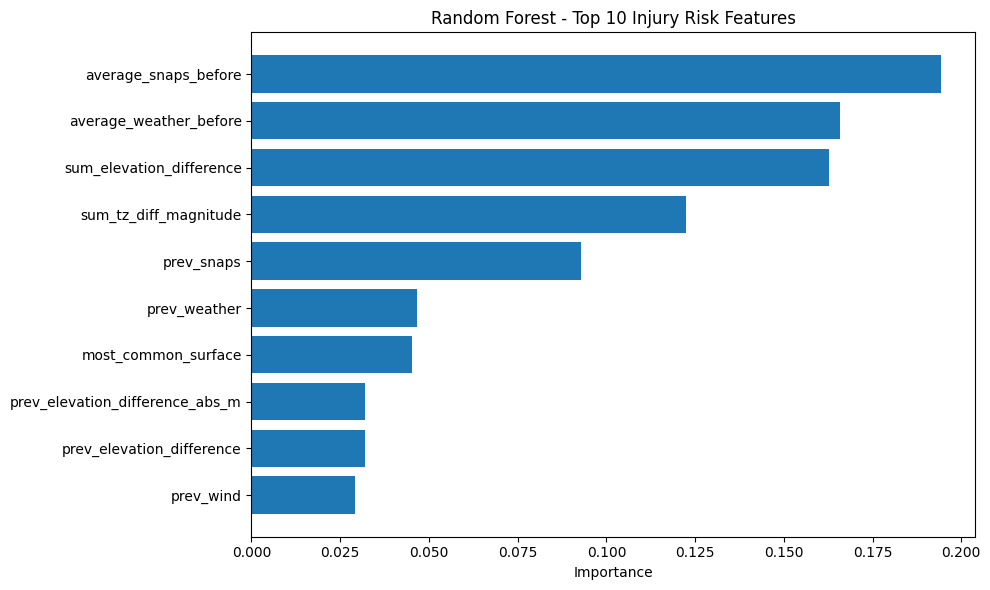

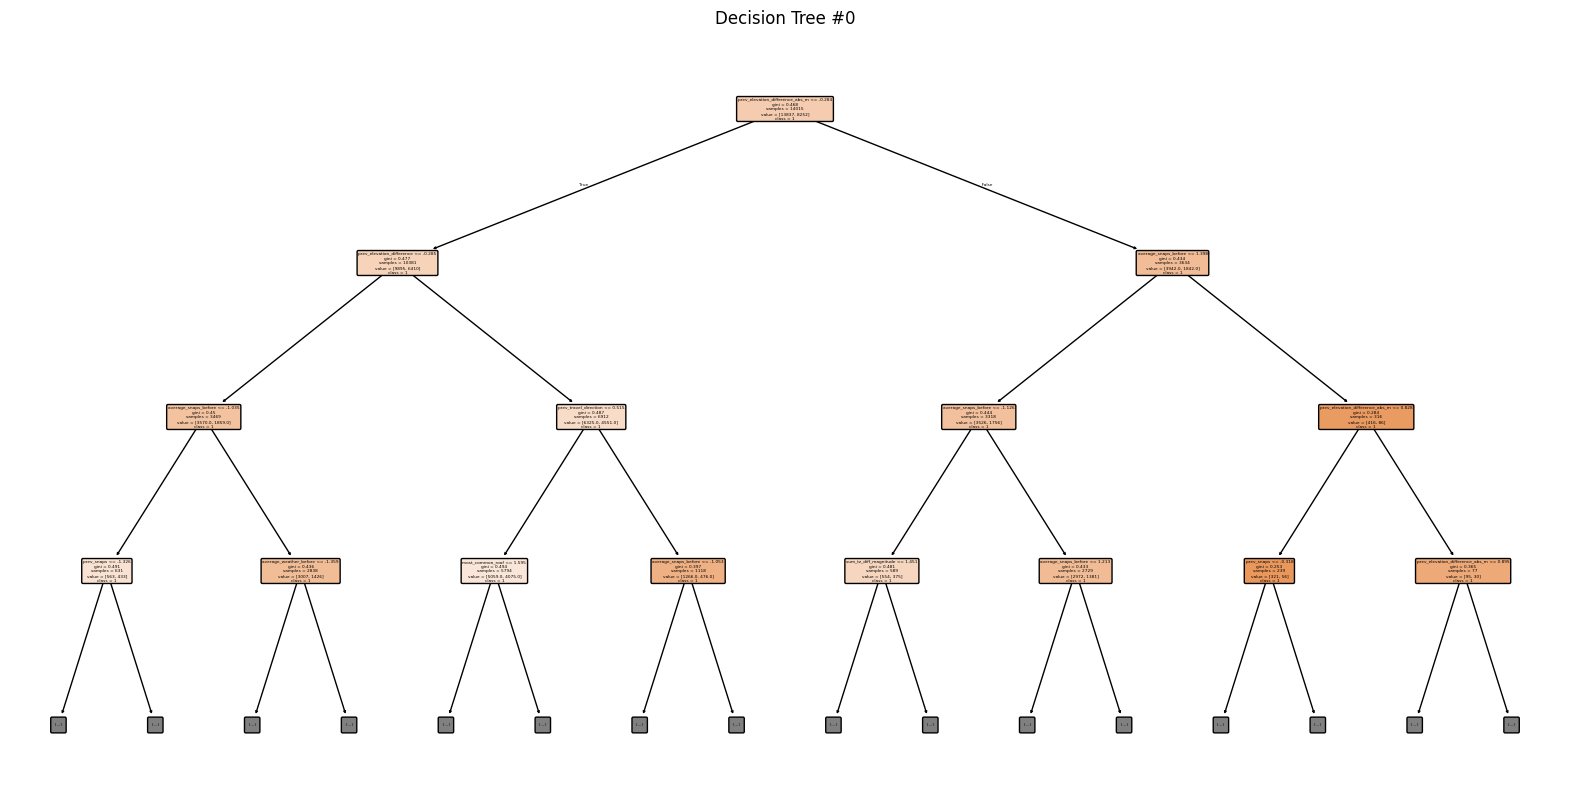


Training XGBoost...
Converting labels from [1, 2] to [0, 1]...
Accuracy: 0.643
Classification Report:
              precision    recall  f1-score   support

       Minor       0.67      0.83      0.74      3427
    Moderate       0.55      0.34      0.42      2096

    accuracy                           0.64      5523
   macro avg       0.61      0.59      0.58      5523
weighted avg       0.63      0.64      0.62      5523


Top 10 Most Important Features for Injury Prediction:
                 feature  importance
   prev_travel_direction    0.168312
              prev_snaps    0.114059
sum_elevation_difference    0.064293
    average_snaps_before    0.063235
     most_common_surface    0.062557
            prev_surface    0.061929
        most_common_roof    0.061574
  average_weather_before    0.060928
   sum_tz_diff_magnitude    0.060252
            prev_weather    0.060131


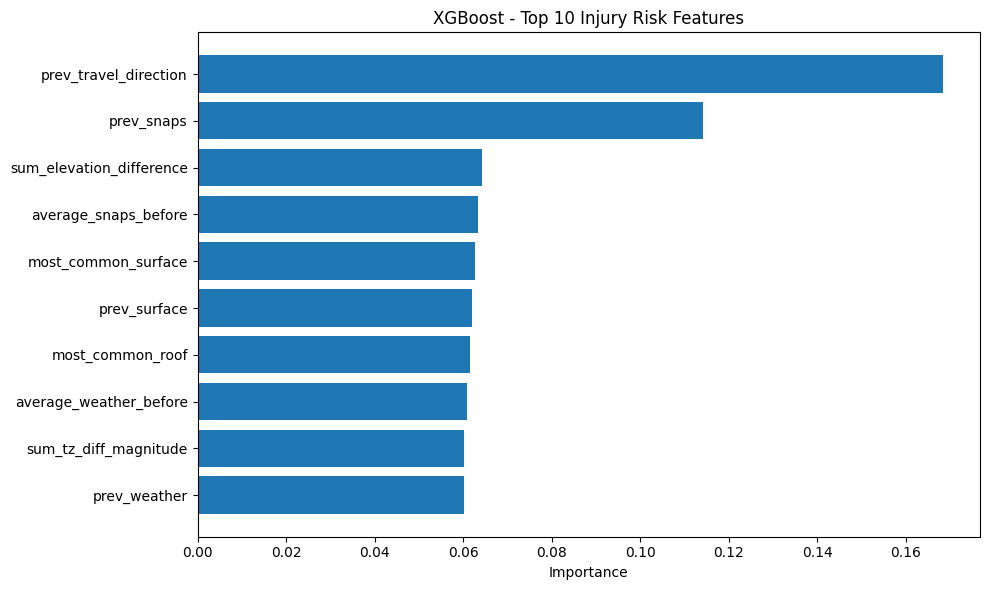

Error training XGBoost: 'XGBClassifier' object has no attribute 'estimators_'

MODEL 2: POST-INJURY PERFORMANCE PREDICTION

Predicting 111 performance metrics...

pass_cmp_x...

  Feature Importance for Predicting pass_cmp_x:
        feature         encoded_feature  importance
       position        position_encoded    0.875583
injury_location injury_lcoation_encoded    0.100803
practice_status practice_status_encoded    0.023615


<Figure size 2000x1000 with 0 Axes>

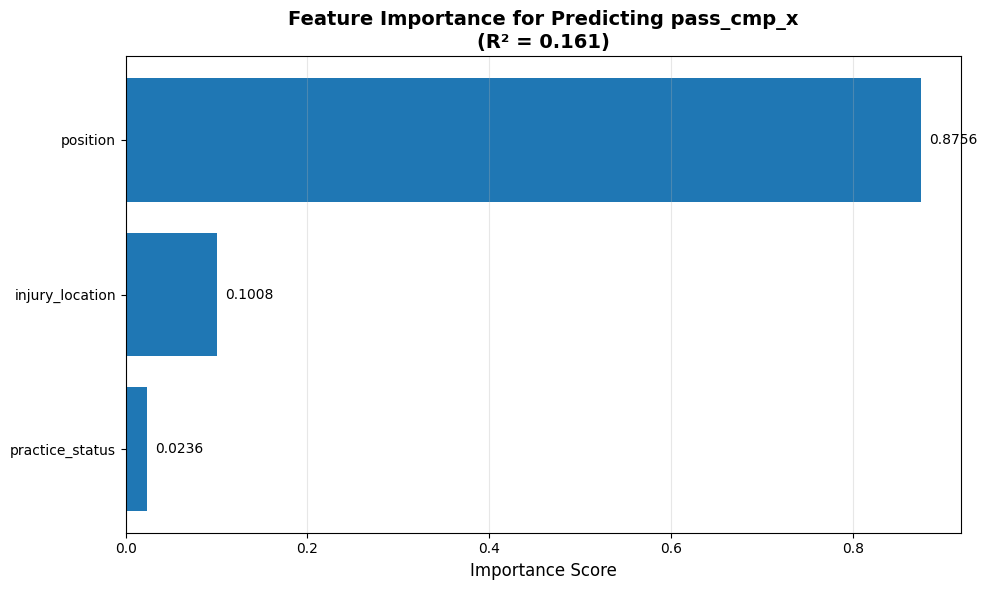

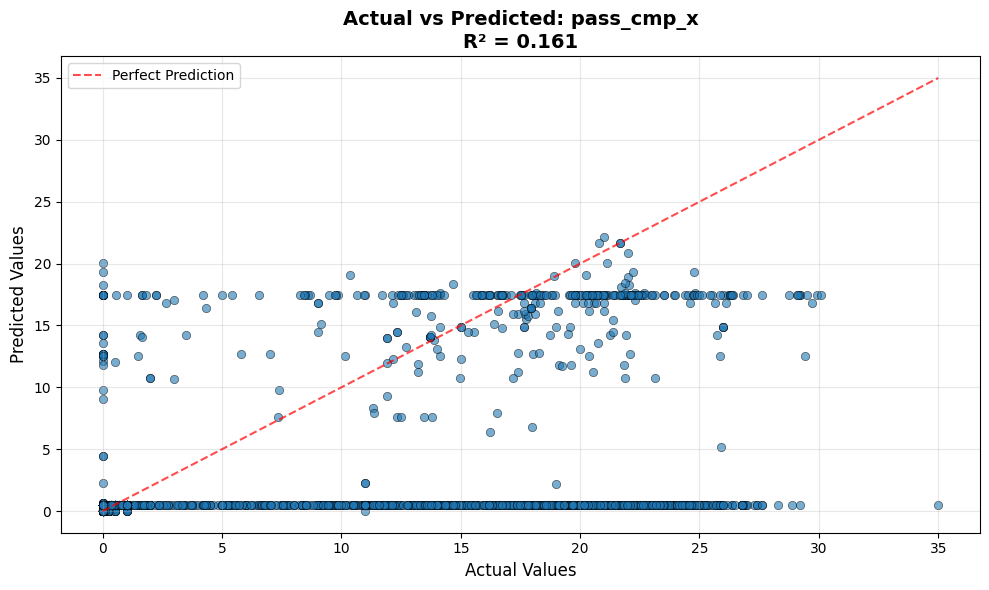


pass_att...

  Feature Importance for Predicting pass_att:
        feature         encoded_feature  importance
       position        position_encoded    0.878101
injury_location injury_lcoation_encoded    0.098919
practice_status practice_status_encoded    0.022979


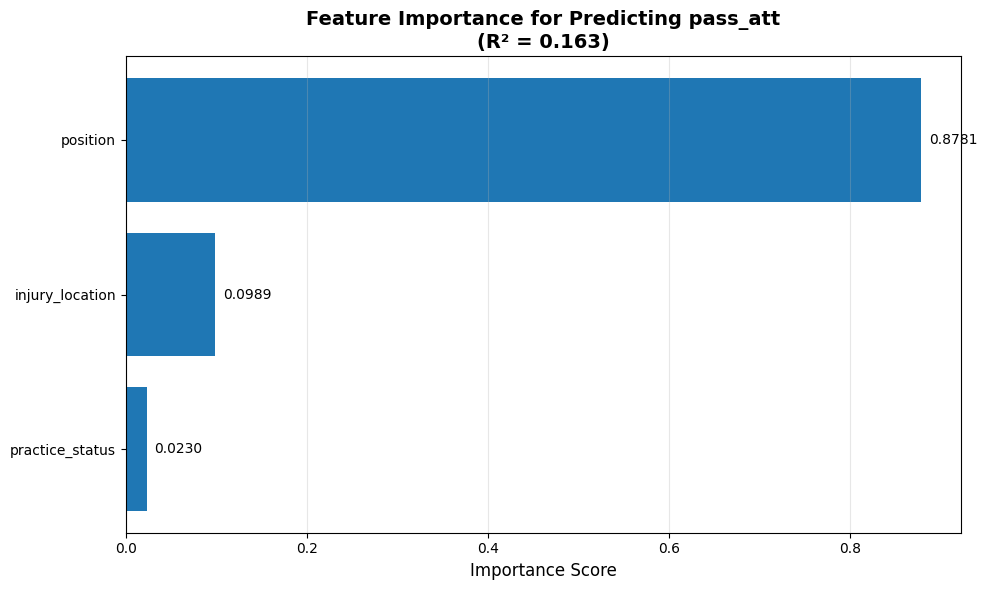

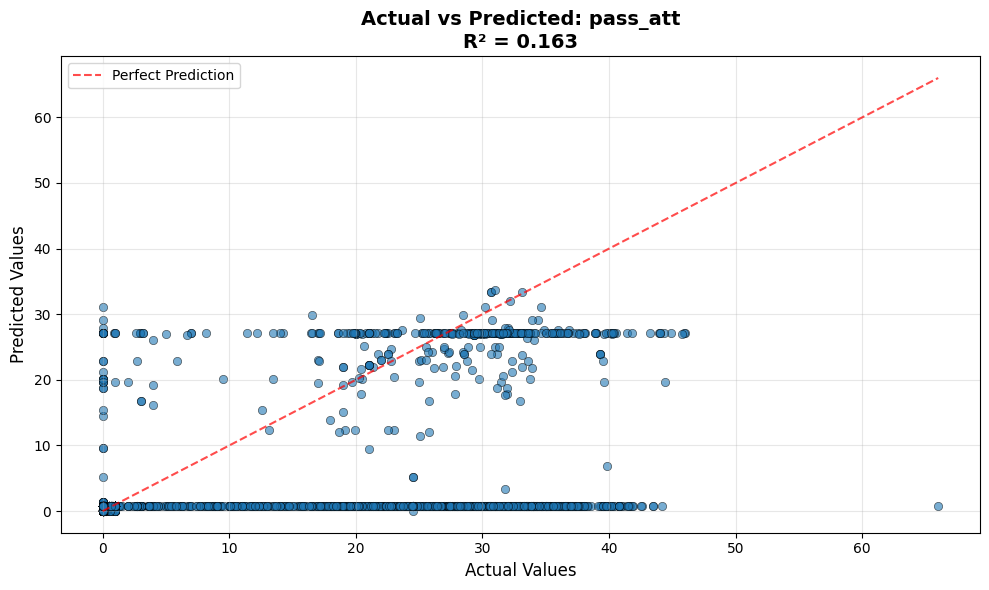


pass_yds...

  Feature Importance for Predicting pass_yds:
        feature         encoded_feature  importance
       position        position_encoded    0.870451
injury_location injury_lcoation_encoded    0.104551
practice_status practice_status_encoded    0.024998


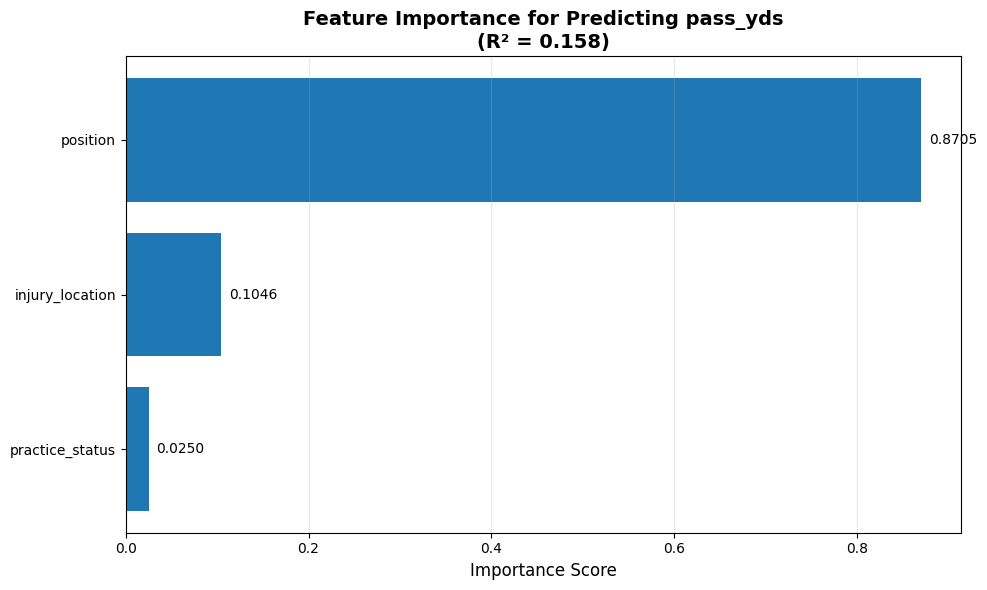

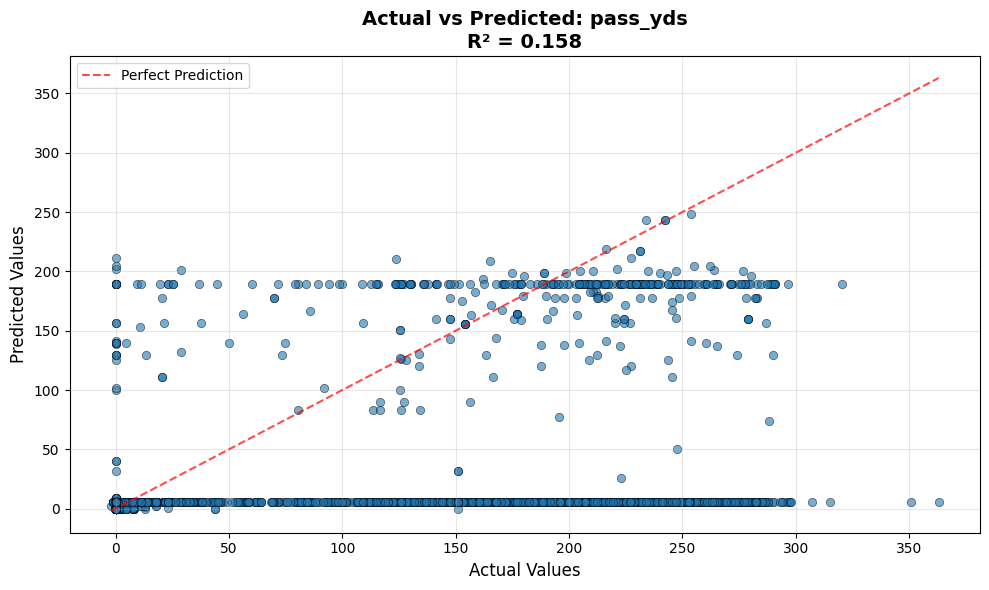


pass_td...

  Feature Importance for Predicting pass_td:
        feature         encoded_feature  importance
       position        position_encoded    0.846026
injury_location injury_lcoation_encoded    0.124745
practice_status practice_status_encoded    0.029229


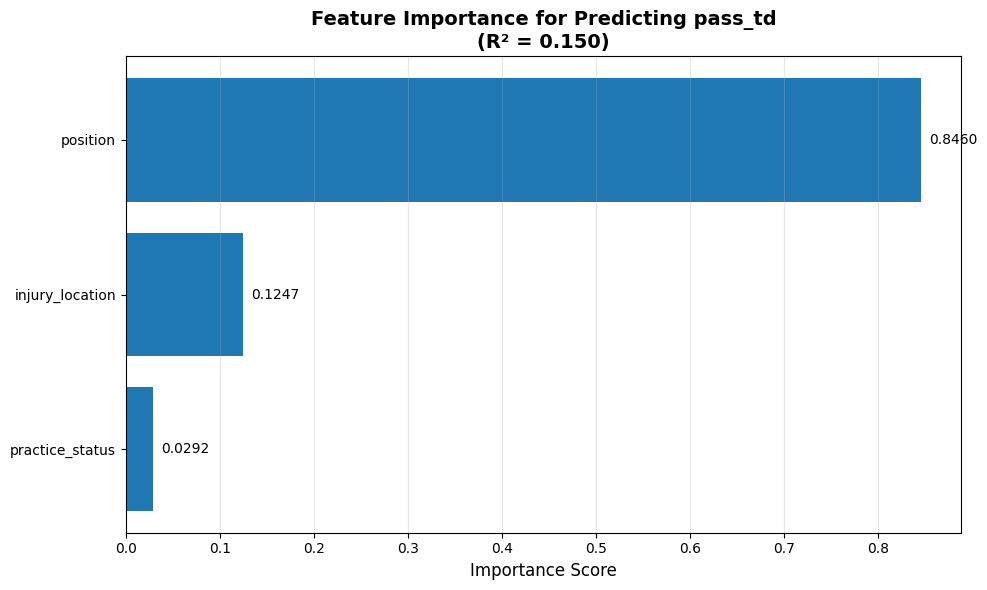

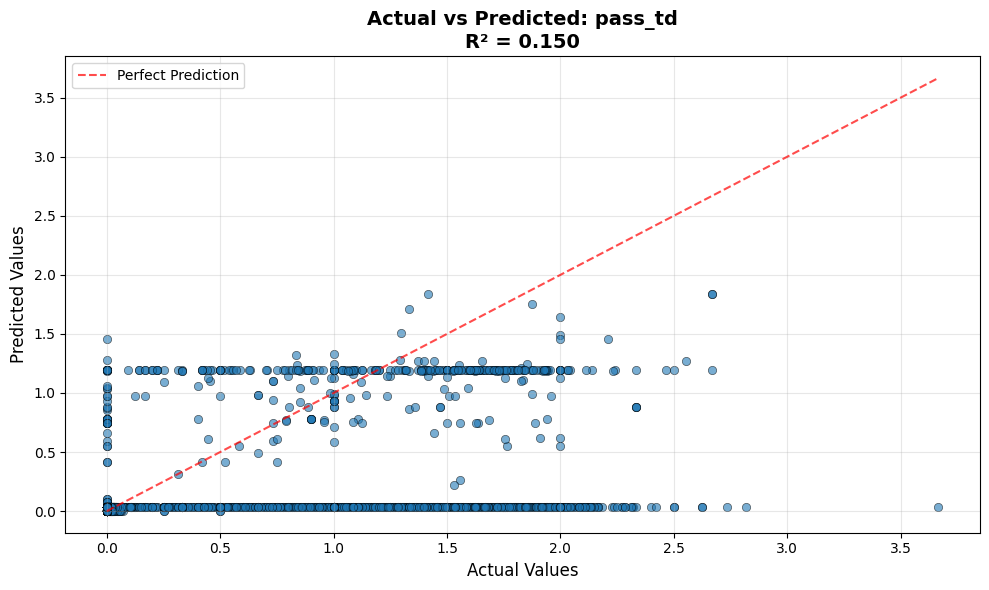


pass_int...

  Feature Importance for Predicting pass_int:
        feature         encoded_feature  importance
       position        position_encoded    0.840288
injury_location injury_lcoation_encoded    0.131443
practice_status practice_status_encoded    0.028269


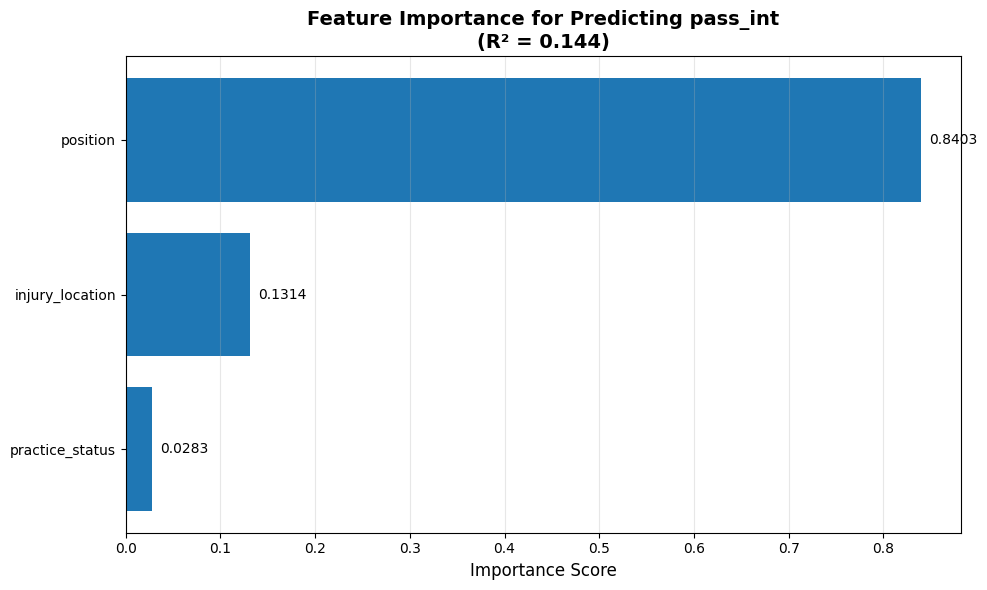

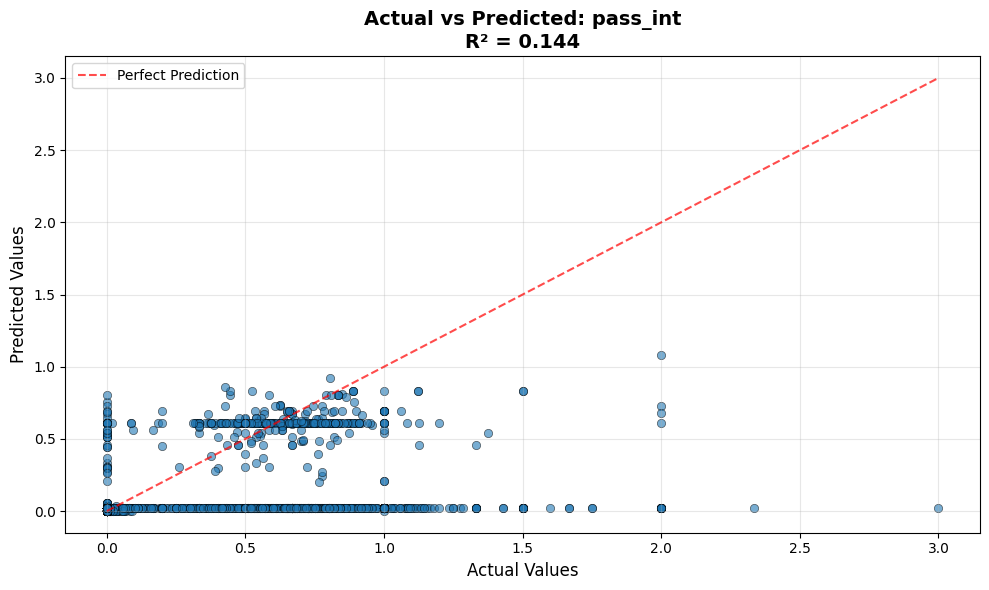


pass_sacked_x...

  Feature Importance for Predicting pass_sacked_x:
        feature         encoded_feature  importance
       position        position_encoded    0.867715
injury_location injury_lcoation_encoded    0.108568
practice_status practice_status_encoded    0.023716


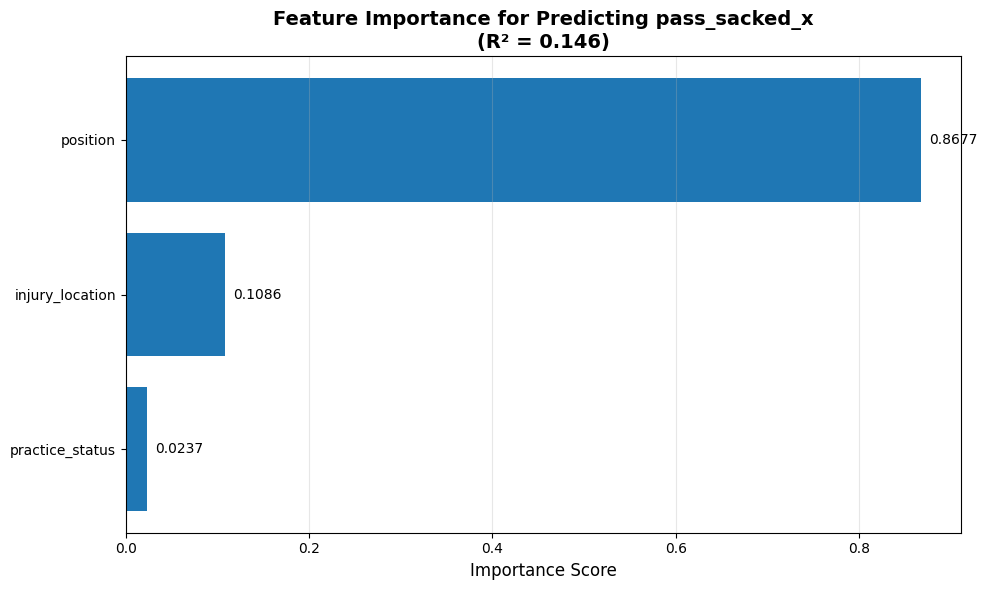

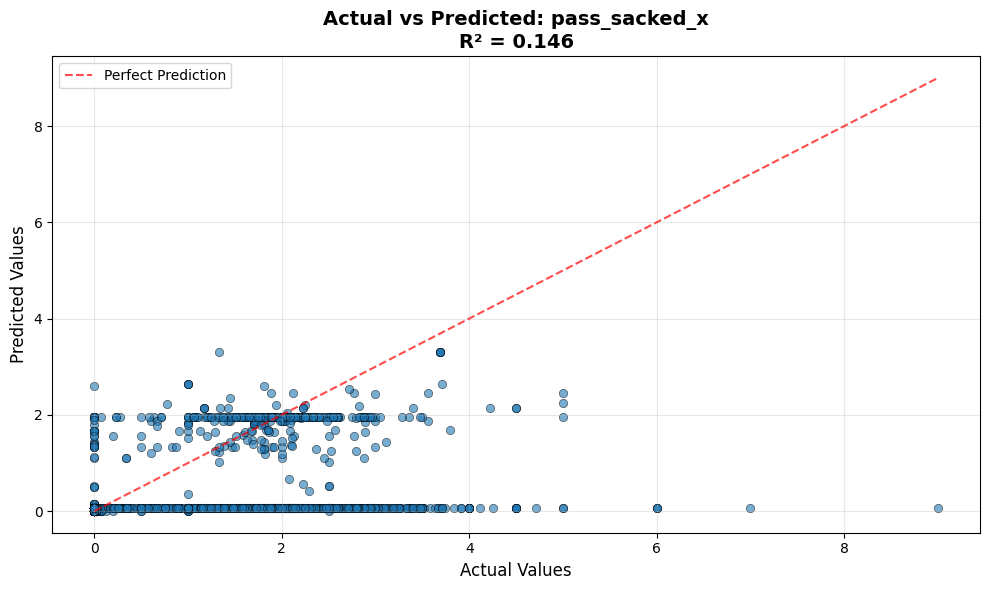


pass_sacked_yds...

  Feature Importance for Predicting pass_sacked_yds:
        feature         encoded_feature  importance
       position        position_encoded    0.873740
injury_location injury_lcoation_encoded    0.103643
practice_status practice_status_encoded    0.022617


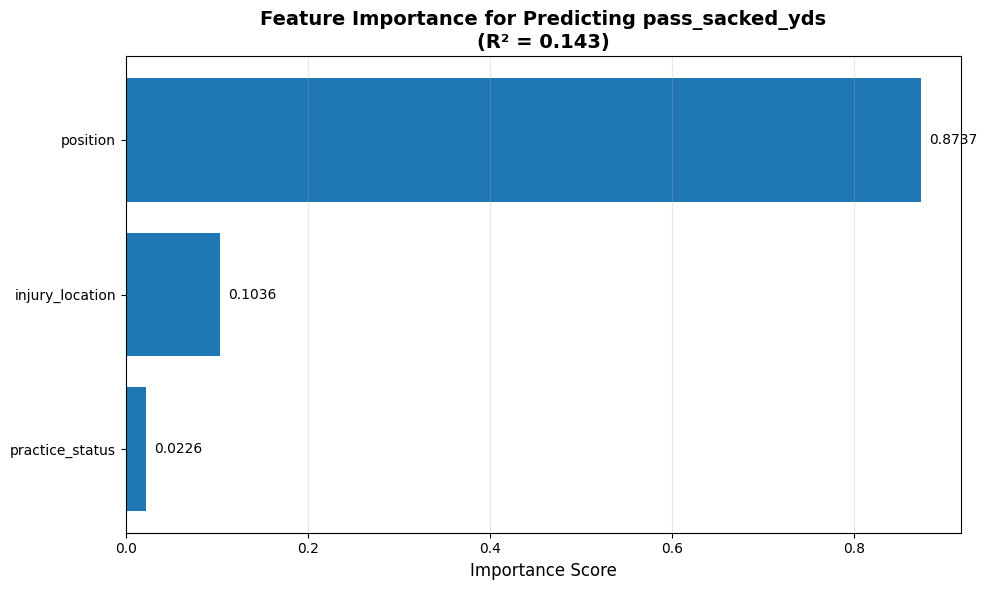

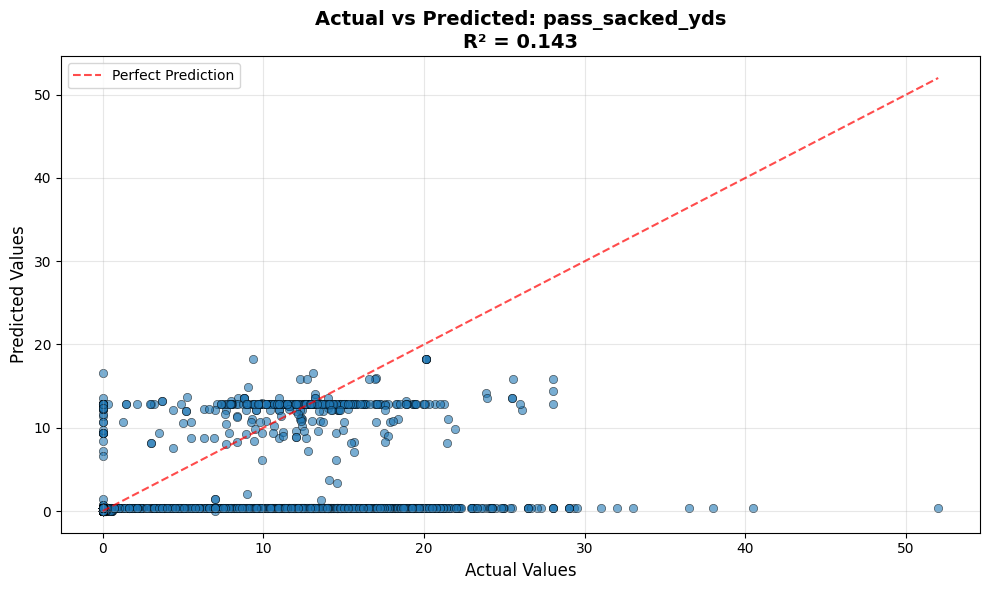


pass_long...

  Feature Importance for Predicting pass_long:
        feature         encoded_feature  importance
       position        position_encoded    0.874491
injury_location injury_lcoation_encoded    0.102292
practice_status practice_status_encoded    0.023216


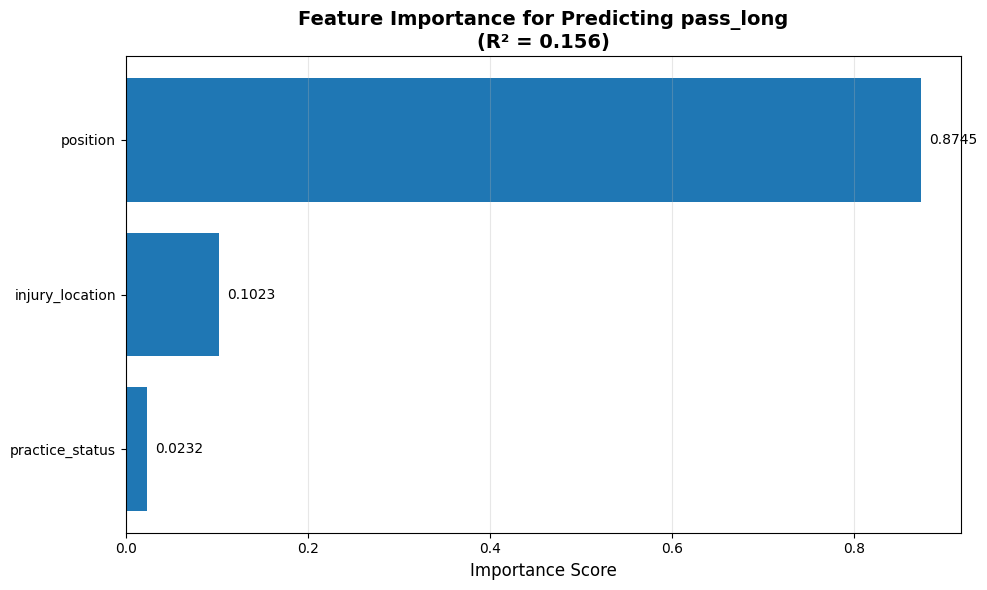

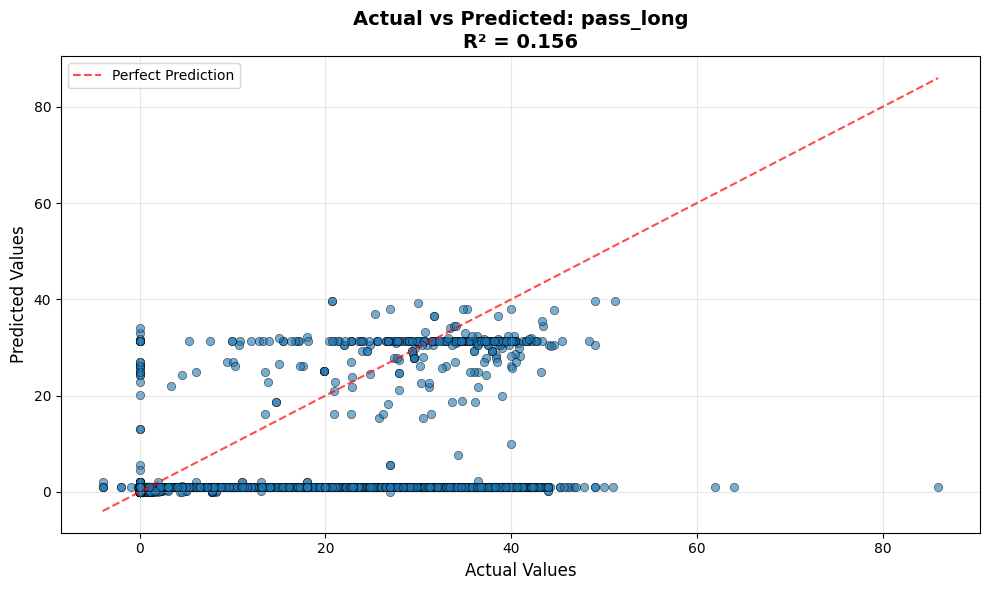


pass_rating...

  Feature Importance for Predicting pass_rating:
        feature         encoded_feature  importance
injury_location injury_lcoation_encoded    0.748167
practice_status practice_status_encoded    0.198994
       position        position_encoded    0.052838


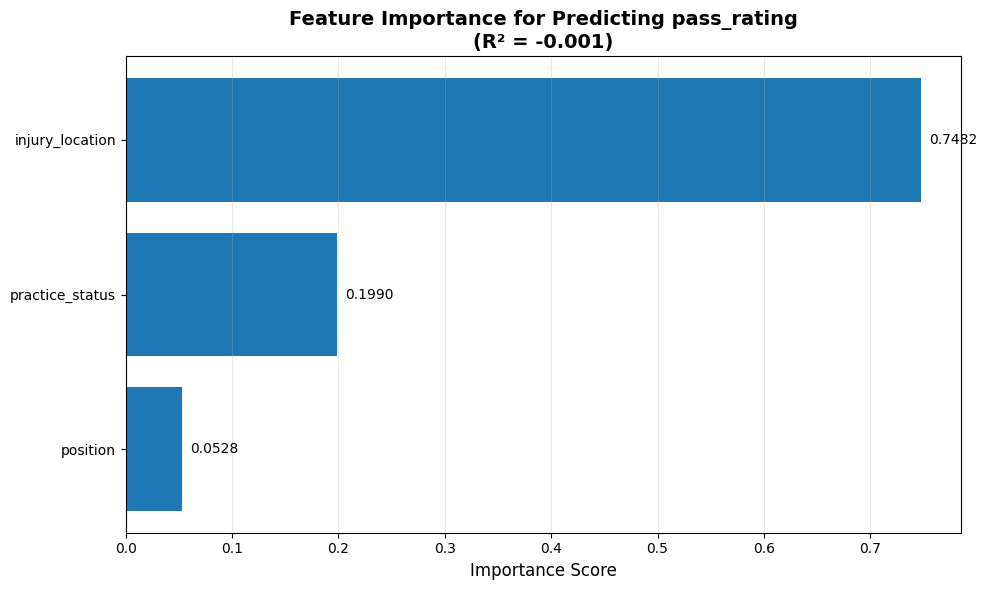

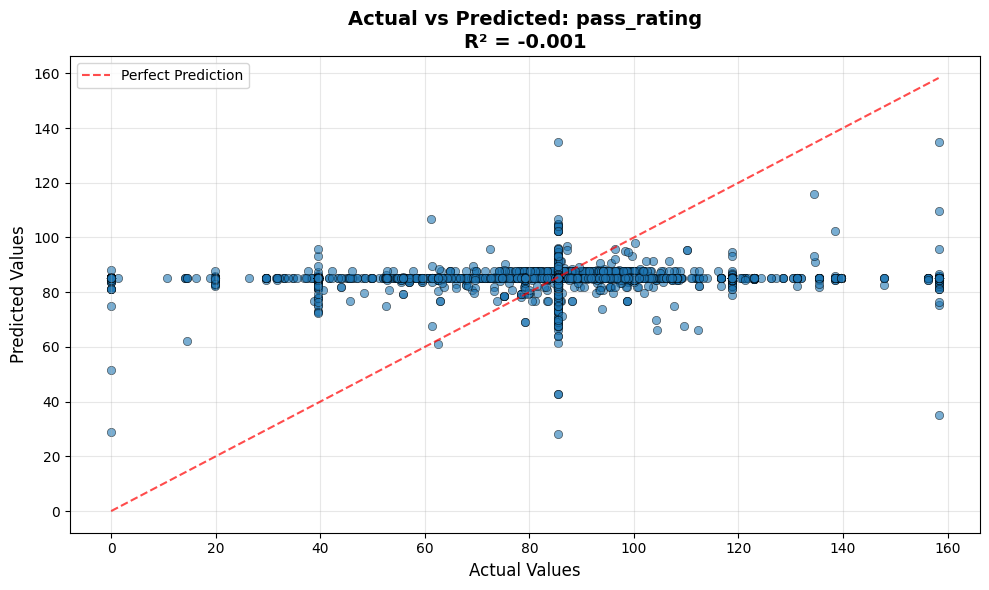


rush_att_x...

  Feature Importance for Predicting rush_att_x:
        feature         encoded_feature  importance
       position        position_encoded    0.899937
injury_location injury_lcoation_encoded    0.065532
practice_status practice_status_encoded    0.034531


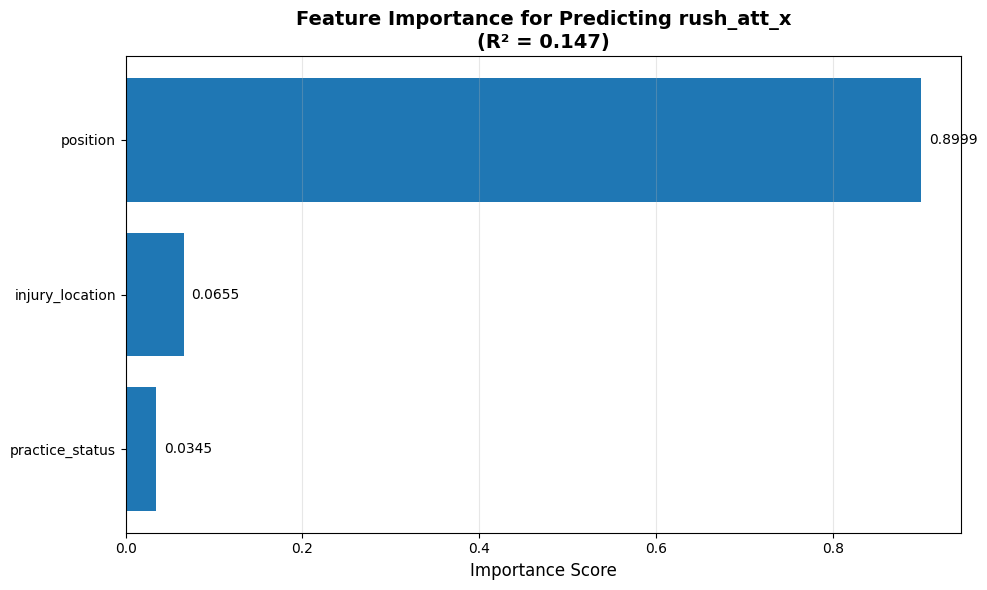

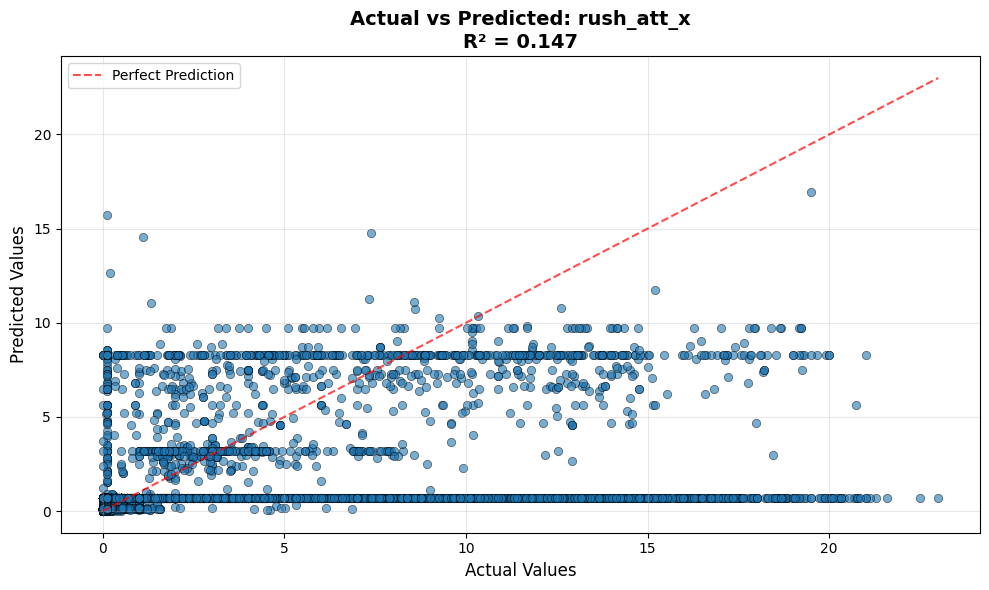


Completed 10 performance models
Starting Integrated Analysis

DEBUG: Initial Data
Data shape: (307636, 138)
Number of features: 128
Selected features shape: (307636, 128)
float64    123
int64        5
Name: count, dtype: int64

Raw numpy array shape: (307636, 128)
NaN count in raw array: 3076360

After preprocessing shape: (307636, 118)
NaN count after preprocessing: 0

Data preparation successful
Final data shape: (307636, 118)
No NaN values remaining

Performing clustering analysis...
  K=2, Inertia=30136181.82
  K=3, Inertia=28077490.19
  K=4, Inertia=26160958.35
  K=5, Inertia=24502616.86
  K=6, Inertia=23166514.98
  K=7, Inertia=22792180.43
  K=8, Inertia=22026257.53
  K=9, Inertia=21509623.14
  K=10, Inertia=21429953.65


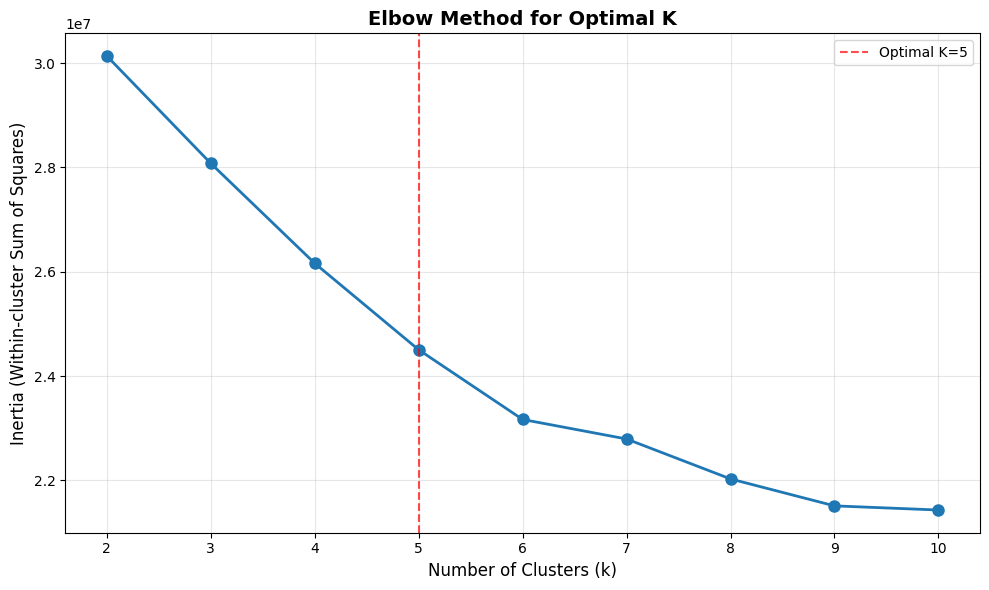


Selected Optimal K = 5 based on elbow method

Cluster Distribution


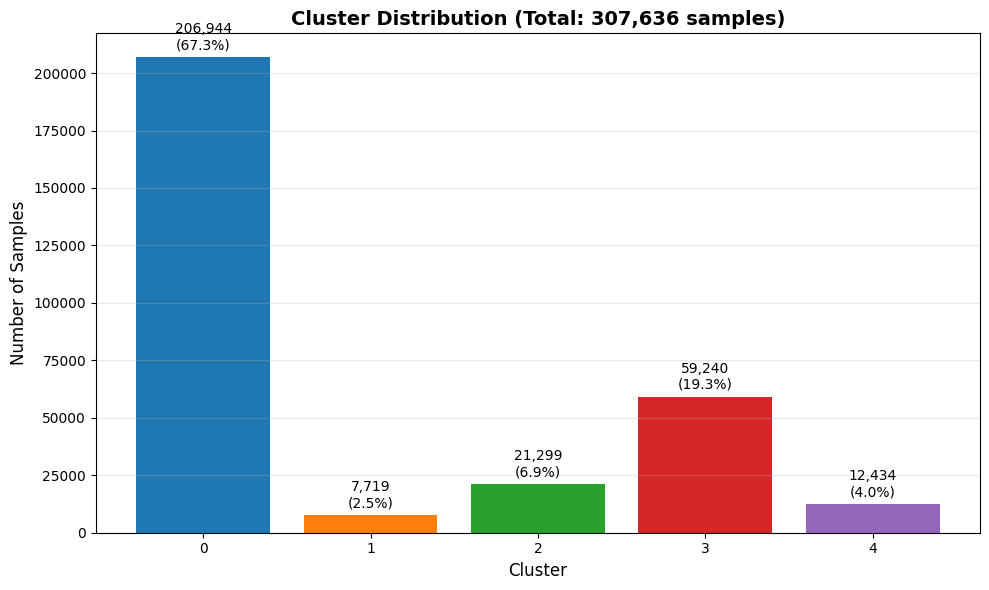


Cluster Sizes:
  Cluster 0: 206,944 samples (67.3%)
  Cluster 1: 7,719 samples (2.5%)
  Cluster 2: 21,299 samples (6.9%)
  Cluster 3: 59,240 samples (19.3%)
  Cluster 4: 12,434 samples (4.0%)

2D PCA Visualization


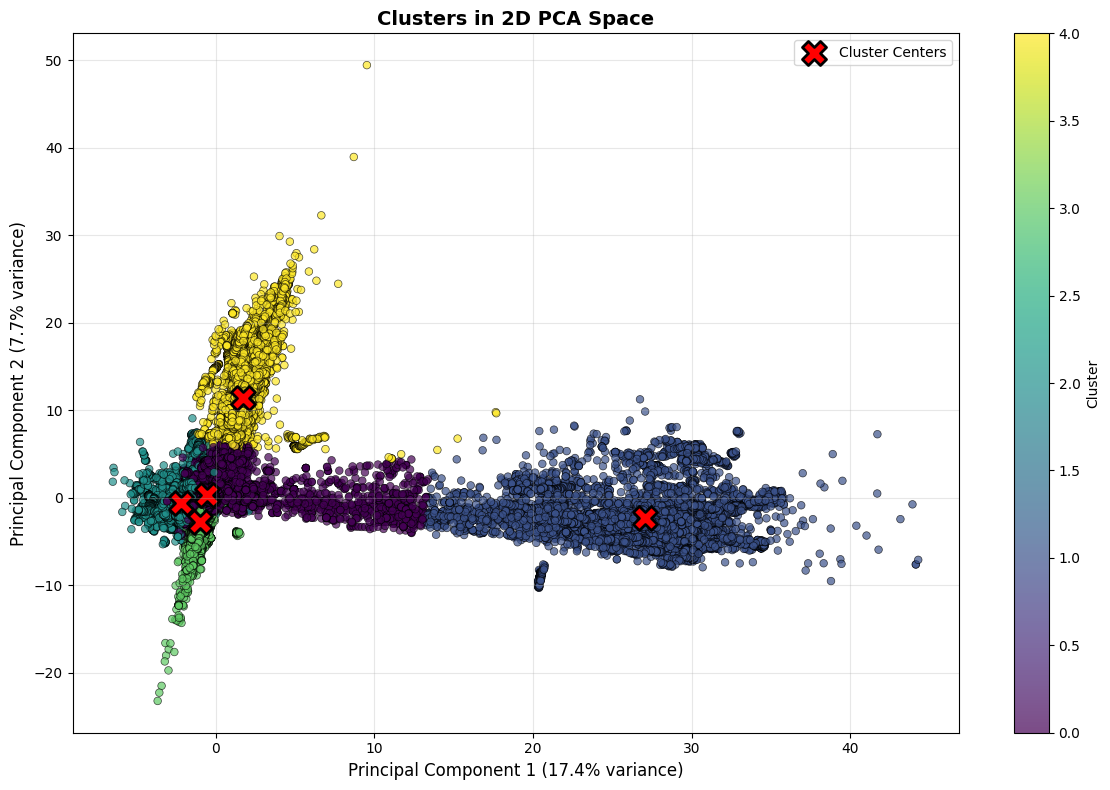

PCA Explained Variance: PC1=17.4%, PC2=7.7%

Cluster Characteristics Heatmap


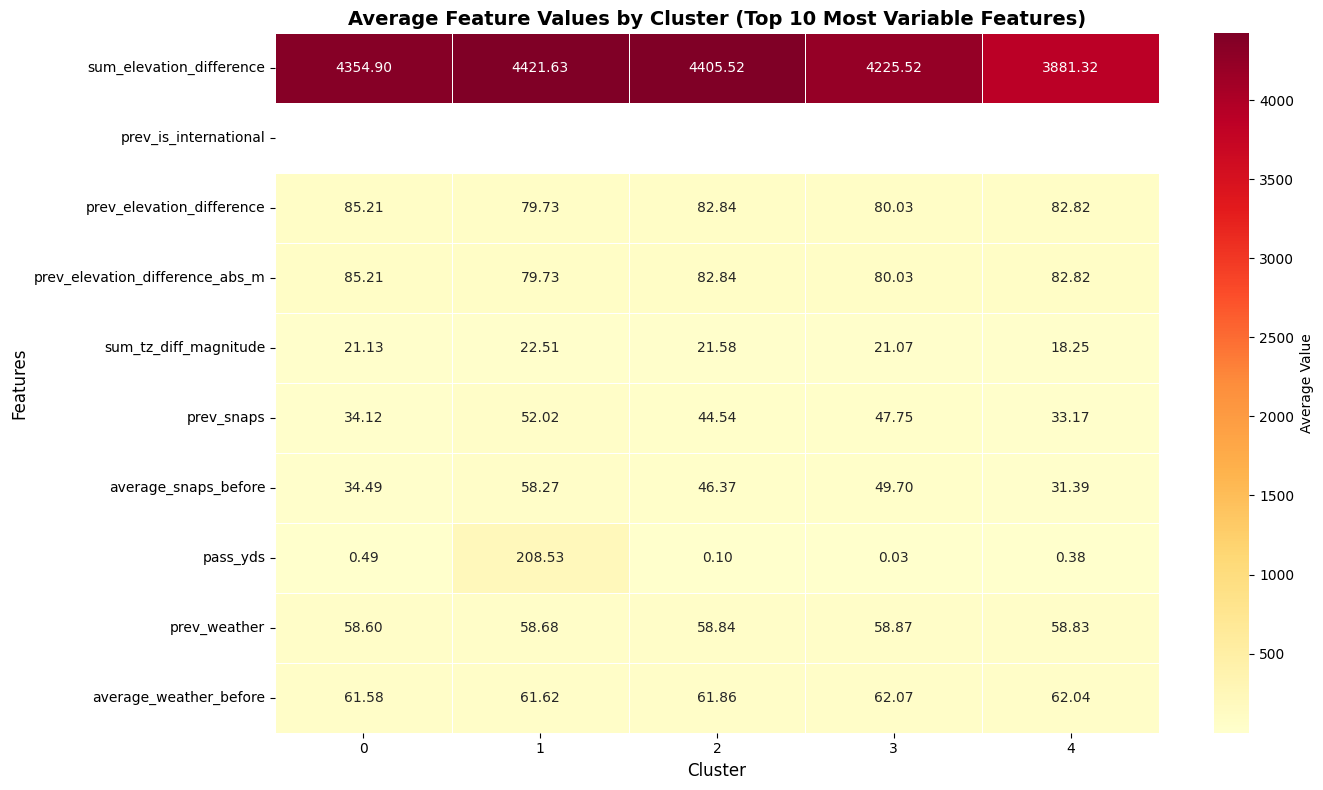


Top 10 Most Variable Features Across Clusters:
   1. sum_elevation_difference: 4787.4424
   2. prev_is_international: nan
   3. prev_elevation_difference: 231.6700
   4. prev_elevation_difference_abs_m: 231.6700
   5. sum_tz_diff_magnitude: 20.2808
   6. prev_snaps: 17.6248
   7. average_snaps_before: 14.3804
   8. pass_yds: 12.9468
   9. prev_weather: 11.8066
  10. average_weather_before: 7.8604

Parallel Coordinates Plot


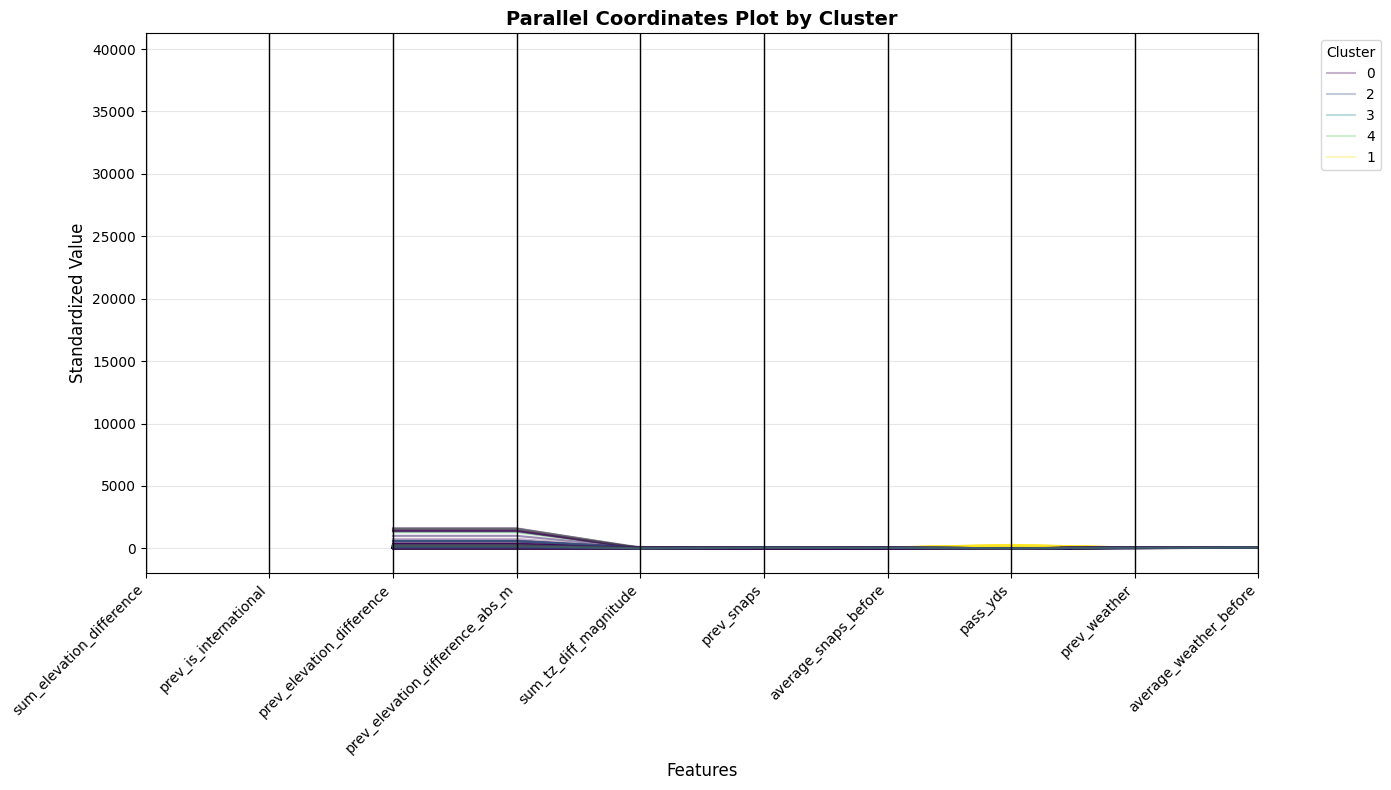

Parallel coordinates plot created with 1,000 samples

Cluster Summary Statistics

Cluster Centroids (Top 5 Features):
         sum_elevation_difference  prev_is_international  prev_elevation_difference  prev_elevation_difference_abs_m  sum_tz_diff_magnitude
Cluster                                                                                                                                    
0                        4354.895                    NaN                     85.214                           85.214                 21.126
1                        4421.633                    NaN                     79.730                           79.730                 22.510
2                        4405.519                    NaN                     82.838                           82.838                 21.579
3                        4225.525                    NaN                     80.028                           80.028                 21.068
4                        3881.316         

In [8]:
# ============================================================================
# EXECUTION
# ============================================================================


df = pd.read_csv('clean_data/agged_data2.csv')

# clean up some of the features
df["prev_wind"] = (
    df["prev_wind"]
    .astype(str)
    .str.replace("mph", "", regex=False)
    .str.strip()
)

df["prev_wind"] = pd.to_numeric(df["prev_wind"], errors="coerce")

df["prev_travel_magnitude"] = df["prev_travel_magnitude"].replace({
    "home": 0,
    "short": 1,
    "medium": 2,
    "long": 3
})

numeric_cols = [
    "average_humidity_before",
    "average_wind_before",
    "prev_humidity",
    "prev_wind"
]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")


# Run the complete pipeline
analysis_results = run_injury_analysis_pipeline(df)

# Save results
# analysis_results['data'].to_csv('injury_analysis_results.csv', index=False)
print("\nAnalysis complete!")